In [1]:
%set_env GOOGLE_APPLICATION_CREDENTIALS=C:\Users\Mark\Desktop\PurdueEats-e85c448de7a4.json

env: GOOGLE_APPLICATION_CREDENTIALS=C:\Users\Mark\Desktop\PurdueEats-e85c448de7a4.json


In [18]:
from google.cloud import bigquery
import sys
from backend.DB.Util import runQuery
from backend.API.routes.menu import get_nutrition, nutrition_to_macros, get_menu_item
import pandas as pd
import datetime

gcp_project = "purdueeats-304919"
bq_dataset = "PurdueEatsDatabase"

client = bigquery.Client(project=gcp_project)
dataset_ref = client.dataset(bq_dataset)

def userReviewsSummary(UserID):
    reviews = runQuery( f"select user.UserID, MenuItemID, Rating, Timestamp from UserBasic as user Inner Join MenuItemsReviews as txn on user.UserID = txn.UserID WHERE user.UserID = {UserID}")
    return reviews.to_dataframe()

def userTransactionsSummary(UserID):
    transactions = runQuery( f"select user.UserID, TransactionAmount, Balance, Timestamp from UserBasic as user Inner Join UserTransaction as txn on user.UserID = txn.UserID WHERE user.UserID = {UserID}")
    return transactions.to_dataframe()

def getMenuItemName(MenuItemID):
    rtn = runQuery( f"select ItemName from MenuItems WHERE MenuItemID = {MenuItemID}").to_dataframe()
    rtn.columns = [''] * len(rtn.columns)
    return rtn

def getMenuItemDetails():
    res = [dict(row) for row in runQuery(
        f"select MenuItemID, ItemName, HashID from MenuItems")]

    rtn = dict()
    xtn = dict()

    for x in res:
        rtn[x['MenuItemID']] = x['ItemName']
        xtn[x['MenuItemID']] = x['HashID']
    
    return rtn, xtn

In [20]:
rtn

{45: 'Italian Sausage',
 32: 'Strawberry Gelatin',
 33: 'Gluten Free Cookies',
 35: 'Hamburger',
 36: 'Blackened Beef Burger',
 34: 'Italian Ice',
 30: 'Salad Bar ',
 31: 'Garlic Herb Roasted Chicken Drumsticks',
 69: 'Green Lentils',
 54: 'Grilled Hot Dog',
 67: 'Grilled Chicken Breast',
 70: 'Cajun Chicken Drumsticks',
 91: 'Roasted Cajun Chicken Drumsticks',
 85: 'Quesadilla Toppers',
 117: 'Dirty Rice',
 99: 'Cuban Pork Loin',
 115: 'Sausage Pizza',
 111: 'Mini Spring Rolls',
 136: 'Freshly Baked Vegan Cookies',
 130: 'Chicken Shawarma',
 159: 'Firehouse Chili with Pork',
 135: 'Vegan Salads ',
 162: 'Honey Lime Chicken',
 172: 'Philly Steak',
 158: 'Super Beef Hot Dog',
 152: 'Hand Held Fruit',
 141: 'Bacon Bits',
 161: 'Salad Bar ',
 124: 'Philly Steak',
 216: 'Roasted Albuquerque Chicken Breast',
 206: 'Beef Barbacoa',
 214: 'Mint Frosting',
 203: 'Cocktail Sauce Cup ',
 188: 'Fruit Punch and Sprite',
 189: 'Grilled Pork Tenderloin',
 197: 'Sausage and Cabbage',
 187: 'Pork Pots

In [21]:
xtn

{45: 'b3a5c7e9-3786-4dbb-82ae-e04ae959d613',
 32: 'ab24665f-bbc5-4782-b5e7-e6bc4677281e',
 33: '9ba6364c-fff7-4333-87f0-a20ac32984b7',
 35: 'b82a53af-81b4-4ea0-a5b2-c0eec2a6c1bb',
 36: '91e71f82-109b-479b-aa53-ac4b74f11f52',
 34: '0944faba-c4c3-46ca-b2bb-bdbd2406ba60',
 30: 'd2a67e1e-7920-43b4-a009-19816b807425',
 31: 'a2bb8baa-5594-4f02-a039-505c65b017ce',
 69: 'a100c0d8-45c5-489a-b4f0-6ba494273126',
 54: '49884e4e-1f3e-4214-b381-49c6083e7e0e',
 67: '78a7cea6-7b95-4e26-ad7d-a3be9aedeb6f',
 70: '85ecf9b6-b9f1-4be1-af49-b86b73dd5122',
 91: 'ee24bea7-3b49-4ba4-8fdd-897b54002d76',
 85: 'fb29b0cb-d2c2-4694-8de8-5b902559c9bf',
 117: '93ae2e2b-68f5-414a-8436-fd832467b864',
 99: 'c990e9a7-76f0-4b52-8121-a79eef7e4397',
 115: '768ff5e1-f3e3-4845-a89c-75df2d6a67d2',
 111: '8250ca53-98cb-4ba9-9699-c760e1375c3d',
 136: '21bb2253-5d84-4c3e-9bb3-1dcc7d68804e',
 130: 'be82ff32-3538-4529-a22c-02fd9f975006',
 159: '19123923-a62f-49a9-b2c8-b22372789346',
 135: '6dd08fb6-ea72-47c3-ba02-0a467cfb5a5f',
 16

df = userReviewsSummary(7023699889393535879) #use 7023699889393535879 for example
df['first_day_of_week'] = df["Timestamp"].apply(lambda df:
                                        datetime.datetime(year=df.year, month=df.month, day=df.day))
df.set_index(df["first_day_of_week"], inplace=True) #makes lines 56-59 run

calories = [] #these empty lists will be populated with in the for loop below, then added as columns to dataset.
carbs = []
fat = []
protein = []
menuItemStr = []

for i, row in df.iterrows():
    menu_item_id = row[1] #this is the menu item id
    menuItemStr.append(getMenuItemName(menu_item_id).loc[0].to_string()[4:])
    response = get_nutrition(menu_item_id)
    _calories, _carbs, _fat, _protein = nutrition_to_macros(response)
    calories.append(_calories)
    carbs.append(_carbs)
    fat.append(_fat)
    protein.append(_protein)
df['calories'] = calories
df['carbs'] = carbs
df['fat'] = fat
df['protein'] = protein
df['menuItemStr'] = menuItemStr

weekly_avg_calories = df.calories.resample('W').sum() / df.first_day_of_week.resample('W').count()
weekly_avg_carbs = df.carbs.resample('W').sum() / df.first_day_of_week.resample('W').count()
weekly_avg_fat = df.fat.resample('W').sum() / df.first_day_of_week.resample('W').count()
weekly_avg_protein = df.protein.resample('W').sum() / df.first_day_of_week.resample('W').count()
#sum of total calories per week / number of active input days per week

#counting unique occurences
df['menuItemStr'] = df['menuItemStr'].str.split()
menu_item_count = df['menuItemStr'].apply(pd.Series).stack().reset_index(drop=True).value_counts()
#menu_item_count = df['MenuItemID'].value_counts() #obsolete line that returns menu item id with count

# this is to calculate user transactions
df2 = userTransactionsSummary(7023699889393535879)
df2['first_day_of_week'] = df2["Timestamp"].apply(lambda df2:
                                        datetime.datetime(year=df2.year, month=df2.month, day=df2.day))
df2.set_index(df2["first_day_of_week"], inplace=True) #makes line 74 run
weekly_summary_trans = df2.TransactionAmount.resample('W').sum()

print("\nMenu Item Count is used for word cloud. It contains the menu item # followed by the count.")
print(f"\nmenu_item_count: \n{menu_item_count}") #frequency count of menu items; for word cloud

print("\nWeekly macro averages are below. They're in Series format and can thus be plotted. The index is the first day of the week, the values are average macro consumed of that week")
print(f"\nweekly_avg_calories: \n{weekly_avg_calories}") #this is a series
print(f"\nweekly_avg_carbs: \n{weekly_avg_carbs}")  # this is a series
print(f"\nweekly_avg_fat: \n{weekly_avg_fat}") #this is a series
print(f"\nweekly_avg_protein: \n{weekly_avg_protein}") #this is a series
print("\nWeekly sum transactions averages are below. They're in the same format as above.")
print(f"\nweekly_summary_trans \n{weekly_summary_trans}") #this is a series.


In [3]:
def mealPlanSummary():
    mealPlans = runQuery( f"SELECT MealPlan.MealPlanName FROM UserBasic INNER JOIN UserExtra ON UserBasic.UserID=UserExtra.UserID INNER JOIN MealPlan ON UserExtra.MealPlanName = MealPlan.MealPlanName")
    return mealPlans.to_dataframe()
    

In [4]:
mealPlansDF = mealPlanSummary()
mealPlansDF

,MealPlanName
0,10 Meal Plan +100
1,15 Meal Plan +450
2,21 Meal Plan +250
3,15 Meal Plan +450
4,15 Meal Plan +450
5,21 Meal Plan +250
6,15 Meal Plan +450
7,21 Meal Plan +500
8,15 Meal Plan +450
9,15 Meal Plan +450


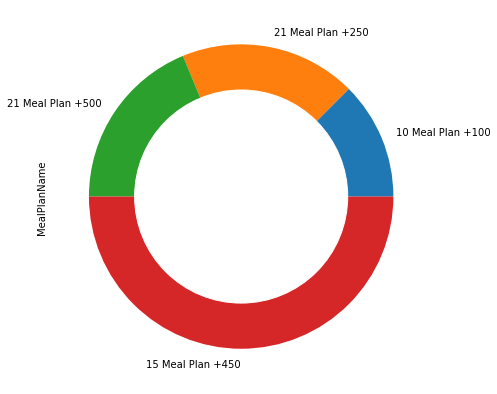

In [5]:
import matplotlib.pyplot as plt
mealPlansDF.MealPlanName.value_counts(sort=False).plot.pie(figsize = (7,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [6]:
def getAllUsers():
    allUsers = runQuery(f"SELECT UserID FROM UserBasic")
    return allUsers.to_dataframe()
allUserID = getAllUsers()

In [46]:
#WARNING: RUNTIME IS A MILLION YEARS

#get all the menu items all users have consumed
rtn, xtn = getMenuItemDetails()

masterList = []

for UserID in allUserID.UserID.tolist():
    print(UserID)
    df = userReviewsSummary(UserID) #use 7023699889393535879 for example
    
    def get_value(keyy, my_dict):
        for key, value in my_dict.items():
            if key == keyy:
                return value
 
        return "key doesn't exist"

    df.MenuItemID = df.MenuItemID.apply(lambda x: get_value(x, rtn))
    df.MenuItemID = df.MenuItemID.astype(str)
    #print(df.MenuItemID)
    #display(df.dtypes)
    menuItemStr =df.MenuItemID.to_list()
    
    
    #counting unique occurences
    if not menuItemStr: #if the list is empty:
        print("User has made no reviews!")
    else:
        df['MenuItemID'] = df['MenuItemID'].str.split()
        masterList.append(df['MenuItemID'].apply(pd.Series).stack().reset_index(drop=True))
masterList

4087605085059207658
8868460133119895895
User has made no reviews!
-2589269694930711347
1589774858082006536
6967645914836607210
8788104928683024331
4467606805034911759
7023699889393535879
-6972977857218552086
-2950671479005323586
0
-7051850150604121449
3183534950451599476
User has made no reviews!
-5179890033796933917
User has made no reviews!
188163777591238077
User has made no reviews!
-8325608802771069211
-644379582692266724
-4518613502442612524
8099793272915706690
-7967665590231560711
User has made no reviews!
6295342170354506735
User has made no reviews!


[0        Yellow
 1          Cake
 2          with
 3       Caramel
 4      Frosting
          ...   
 255     Roasted
 256         Bok
 257        Choy
 258     Brussel
 259     Sprouts
 Length: 260, dtype: object,
 0         Raisins
 1         Vanilla
 2       Sunflower
 3          Butter
 4          Cashew
           ...    
 148         Farro
 149          with
 150    Vegetables
 151           and
 152          Kale
 Length: 153, dtype: object,
 0           Sliced
 1     Strawberries
 2          Raisins
 3             Hard
 4           Cooked
 5             Eggs
 6             Rice
 7             Chex
 8           Cereal
 9         Parmesan
 10         Roasted
 11      Fingerling
 12        Potatoes
 13       Meatballs
 14            with
 15        Marinara
 16          Gluten
 17            Free
 18          Peanut
 19          Butter
 20          Cookie
 21         Roasted
 22       Chickpeas
 23           Fried
 24         Chicken
 25          Gluten
 26            Free
 27   

In [47]:
flatList = [ item for elem in masterList for item in elem] #turn list of lists into single list
d = {x:flatList.count(x) for x in flatList}

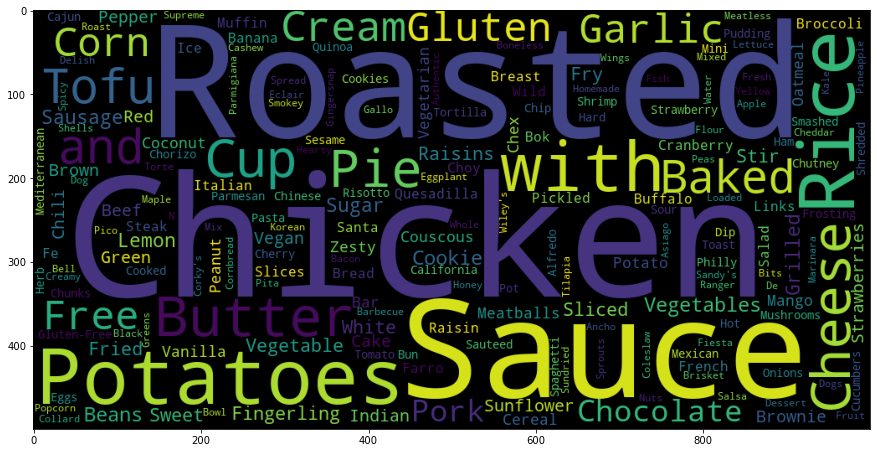

In [48]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

In [12]:
#do all user transactions trends, user transactions trends per meal plan

,UserID
0,4087605085059207658
1,8868460133119895895
2,-2589269694930711347
3,1589774858082006536
4,6967645914836607210
5,8788104928683024331
6,4467606805034911759
7,7023699889393535879
8,-6972977857218552086
9,-2950671479005323586


In [15]:
def allTransactionsSummary():
    transactions = runQuery( f"select UserID, TransactionAmount, Balance, Timestamp from  UserTransaction ")
    return transactions.to_dataframe()
allTransactionsSummary()


,UserID,TransactionAmount,Balance,Timestamp
0,-2950671479005323586,-1000.00,1500.00,2021-04-02 18:46:27+00:00
1,1589774858082006536,56.00,394.00,2021-04-02 19:41:22+00:00
2,1589774858082006536,-556.00,950.00,2021-04-02 19:41:35+00:00
3,-7051850150604121449,-200.00,700.00,2021-04-02 20:19:42+00:00
4,0,100.00,350.00,2021-04-10 06:17:02.034000+00:00
5,7023699889393536000,10.00,330.00,2021-04-10 06:17:02.034000+00:00
6,7023699889393536000,10.00,340.00,2021-04-10 06:17:02.034000+00:00
7,7023699889393536000,10.00,320.00,2021-04-10 06:17:02.034000+00:00
8,0,5.00,445.00,2021-04-10 18:11:44.375000+00:00
9,0,90.00,230.00,2021-04-12 14:36:16.032000+00:00
